<a href="https://colab.research.google.com/github/BioML-UGent/Advanced-AI-for-Bioinformatics/blob/main/PClab_2_optimization_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PC lab #2: Optimization for neural networks

## Preparation

### Model

In [2]:
import torch
import numpy as np

We've seen how to implement a neural network using PyTorch:



In [1]:
import torch.nn as nn

class HyperparameterModel(nn.Module):
    def __init__(self, dimensions_from_input_to_output = [50, 40, 20, 10, 5], dropout = True):
        super().__init__()

        layers = []
        # iterate through all layers:
        for i in range(len(dimensions_from_input_to_output) - 2):
            layer = nn.Linear(dimensions_from_input_to_output[i], dimensions_from_input_to_output[i + 1])
            layers.append(layer)
            layers.append(nn.ReLU())
            if dropout == True:
                layers.append(nn.Dropout(0.2))


        # the last layer separate from the loop because we don't want a ReLU and dropout after the last layer
        layer = nn.Linear(dimensions_from_input_to_output[i+1], dimensions_from_input_to_output[i + 2])
        layers.append(layer)

        # wrap the layers in a sequential
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)



Let's create a model tailored for MNIST datasaet.

In [3]:
model = HyperparameterModel(dimensions_from_input_to_output = [784, 160, 80, 40, 20, 10], dropout = False)

### Data

For the first part of this PC lab, we will work with the MNIST dataset included in `torchvision`. (If you're running this code locally, you may have to pip install torchvision).

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

X_train = train_data.data
y_train = train_data.targets

X_test = test_data.data
y_test = test_data.targets

100%|██████████| 9.91M/9.91M [00:00<00:00, 96.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 30.6MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 111MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.30MB/s]


Our data is images, each data sample has $28 \times 28$ input features, signifying the pixels. In order to feed this data to our model, we will need to flatten these features:

In [5]:
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In addition, the grayscale values of our images go from 0 to 255. It is perhaps good practice to min-max standardize these numbers by dividing through 255:

In [6]:
X_train = X_train / 255
X_test = X_test / 255

Let's split up our training set in a training and validation set and finally wrap our data in a data loader:

In [7]:
np.random.seed(42)
train_indices, val_indices = np.split(np.random.permutation(len(X_train)), [int(len(X_train)*0.8)])
X_val = X_train[val_indices]
y_val = y_train[val_indices]
X_train = X_train[train_indices]
y_train = y_train[train_indices]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, pin_memory=True, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, pin_memory=True, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, pin_memory=True, shuffle=True)

Let's visualize a random batch:

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


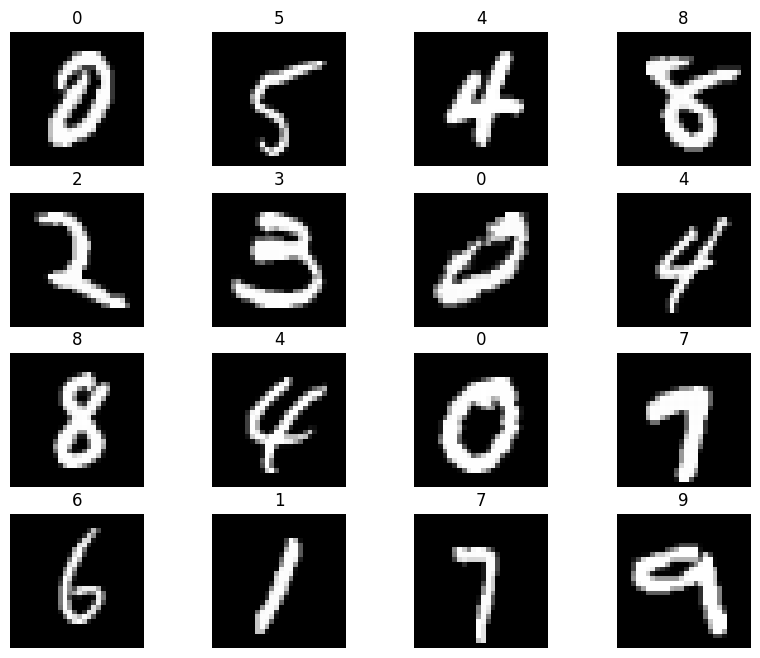

In [8]:
batch = next(iter(train_dataloader))
X_batch, y_batch = batch
import matplotlib.pyplot as plt


figure = plt.figure(figsize=(10, 8))
cols, rows = 4, 4
for i in range(cols * rows):
    img, label = X_batch[i], y_batch[i]
    figure.add_subplot(rows, cols, i+1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img.reshape(-1, 28, 28).squeeze(), cmap="gray")
plt.show()

## 1. Training a neural network

The most basic blueprint of PyTorch model training consists of
- Get your data
- Wrap your data splits in a [data loader](https://pytorch.org/docs/stable/data.html)
- Instantiate the model
- Instantiate a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- Instantiate an [optimizer object](https://pytorch.org/docs/stable/optim.html), to which you pass the parameters you want to optimize
- Iterate through your training data, for every batch:
    - reset the gradients
    - do forward pass
    - compute loss
    - backward pass
    - update parameters

(Optionally):
- After every full iteration through all training data samples (called an epoch), loop through all batches of validation data:
    - forward pass
    - compute loss and validation scores


We already implemented a model compatible with MNIST: 784 input features and 10 output nodes (one for each class). Hence, we can move on to loss function and optimizers. For multi-class classification of the digits, we will need to use the [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss). Take a look at what kind of inputs this loss function expects. According to the documentation: `The input is expected to contain raw, unnormalized scores for each class.` Meaning that we can pass logits directly to this loss function, and we do not have to apply a softmax operation ourselves.

For optimizer, we can choose [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD).

Take note that we can also specify our desired learning rate in our model. This learning should almost always be tuned as it will influence how fast our model trains but also convergence.

In [9]:
model = HyperparameterModel(dimensions_from_input_to_output= [784, 128, 10]) # your model from previous exercises here.

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.005) # SGD = stochastic gradient descent

Now we're ready to perform training. We'll build up the training loop step-wise in the following codeblocks. Let's first start with passing one batch to the model, computing the loss, performing backpropagation and updating the weights:

In [10]:
batch = next(iter(train_dataloader))
X_batch, y_batch = batch

y_hat_batch = model(X_batch)

loss = loss_function(y_hat_batch, y_batch) # Compute loss

loss.backward()   # Calculate gradients
optimizer.step()   # Update weights using defined optimizer

print(X_batch.shape, y_batch.shape)
print(y_hat_batch.shape)
print("Outputs as logits, first two samples:")
print(y_hat_batch[:2])
print('loss:', loss)

torch.Size([16, 784]) torch.Size([16])
torch.Size([16, 10])
Outputs as logits, first two samples:
tensor([[-0.0825, -0.1274,  0.0504,  0.1447, -0.0076, -0.0324,  0.0666,  0.1757,
          0.0754, -0.0701],
        [-0.1049, -0.1202, -0.0224,  0.1287,  0.0193, -0.0273,  0.0155,  0.1610,
          0.1247, -0.1272]], grad_fn=<SliceBackward0>)
loss: tensor(2.3088, grad_fn=<NllLossBackward0>)


Everytime we perform a training step, we should reset the gradients so that the gradients computed on the previous batch do not influence the next. We can do this by calling `.zero_grad()` on our optimizer. In practice, it is most safe to call this before every forward pass. So if we train a complete epoch:

In [11]:
all_losses = []

for batch in train_dataloader:
    optimizer.zero_grad()
    X_batch, y_batch = batch

    y_hat_batch = model(X_batch)

    loss = loss_function(y_hat_batch, y_batch) # Compute loss

    loss.backward()   # Calculate gradients
    optimizer.step()   # Update weights using defined optimizer

    all_losses.append(loss.item())

Plotting the loss function of every batch during one epoch:

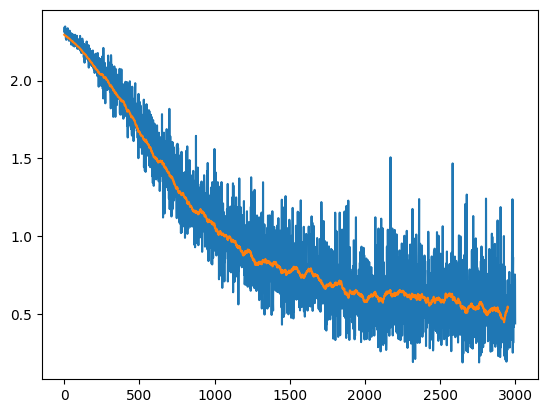

In [12]:
plt.plot(np.arange(len(all_losses)), all_losses)
smoothed_losses = np.convolve(all_losses, np.ones(50)/50, mode = "valid")
plt.plot(np.arange(len(smoothed_losses)), smoothed_losses)

We have evaluated the training progress during one epoch on our training set. What if we want to see the performance of the validation set during training, so that we can see if/when the model starts overfitting? It is common practice to perform a pass through the whole validation set after every training epoch. However, we should not compute gradients now, we can block automatic gradient computation using `torch.no_grad()`. Also, we need to tell PyTorch to put our model in evaluation mode (so it does not perform dropout anymore, etc...). After the validation epoch, we should put the model back to training mode again. The code should look something like this:

In [13]:
predictions = []
true_labels = []
losses = []

model.eval()
with torch.no_grad():
    for batch in val_dataloader:
        X_batch, y_batch = batch

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, y_batch)

        losses.append(loss.item())
        predictions.append(y_hat_batch)
        true_labels.append(y_batch)

model.train()

predictions = torch.cat(predictions)
true_labels = torch.cat(true_labels)
accuracy = (true_labels == predictions.argmax(-1)).sum().item() / len(predictions)

print(accuracy)
print(np.mean(losses))

0.8734166666666666
0.48576552591721217


#### Exercise 1
<div class="alert alert-success">

<p> Using the code above, put it all together to train a model for multiple epochs. After every epoch, print or save some training and validation statistics.

Monitor how good your model is training. What things could you change? In particular, try tweaking the learning rate. How does this influence training?

</p>

</div>

In [23]:
N_EPOCHS = 20

model = HyperparameterModel(dimensions_from_input_to_output= [784, 128, 10]) # your model from previous exercises here.

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1) # SGD = stochastic gradient descent

for i in range(1, N_EPOCHS + 1):
    all_losses = []
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, y_batch) # Compute loss

        loss.backward()   # Calculate gradients
        optimizer.step()   # Update weights using defined optimizer

        all_losses.append(loss.item())
    train_loss = np.mean(all_losses)

    predictions = []
    true_labels = []
    losses = []

    with torch.no_grad():
        model.eval()
        for batch in val_dataloader:
            X_batch, y_batch = batch

            y_hat_batch = model(X_batch)

            loss = loss_function(y_hat_batch, y_batch)

            losses.append(loss.item())
            predictions.append(y_hat_batch)
            true_labels.append(y_batch)

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)
    accuracy = (true_labels == predictions.argmax(-1)).sum().item() / len(predictions)

    print(i, '\t', train_loss, np.mean(losses), accuracy)

1 	 1.6269379754960538 1.4215679737726847 0.52725
2 	 1.6039609294831754 1.3764539744059245 0.46525
3 	 1.5757822116017342 1.517355928103129 0.42733333333333334
4 	 1.598565494229396 1.4041052426099778 0.49266666666666664
5 	 1.6088221246997516 1.590446212689082 0.41875
6 	 1.6454948136309782 1.471370139360428 0.44283333333333336
7 	 1.6431387644410134 1.5604288059075673 0.41241666666666665
8 	 1.6559492866198222 1.6295189198652904 0.37775
9 	 1.639693865855535 1.6061015526453655 0.4474166666666667
10 	 1.6248257231712342 1.4841407081286113 0.428
11 	 1.6561623320579528 1.7360153868993122 0.32133333333333336
12 	 1.7431899697383244 1.7730874851544698 0.3263333333333333
13 	 1.7312866649826368 1.6162161060969036 0.3804166666666667
14 	 1.7485852355360985 1.7568637770811717 0.3119166666666667
15 	 1.7293227893908818 1.6429027061462402 0.41283333333333333
16 	 1.7209434463977813 1.5655908397833507 0.40225
17 	 1.669527527987957 1.5085049088001252 0.4201666666666667
18 	 1.682280196150144 

#### Exercise 2
<div class="alert alert-success">

<p> After training, what is your performance on the test dataset?

You should be able to obtain an accuracy of +- 96%
</p>



</div>

In [15]:
### YOUR CODE HERE ###
predictions = []
true_labels = []
losses = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        X_batch, y_batch = batch

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, y_batch)

        losses.append(loss.item())
        predictions.append(y_hat_batch)
        true_labels.append(y_batch)

predictions = torch.cat(predictions)
true_labels = torch.cat(true_labels)
accuracy = (true_labels == predictions.argmax(-1)).sum().item() / len(predictions)

print(accuracy)
######################

0.96


### Saving a model

After finish training a model, we save the model to disk so that we can load the same weights at a later time. For this, we extract the so-called state_dict from the model which contains all learnable parameters. For our simple model, the state dict contains the following entries:

In [16]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict({'net.0.weight': tensor([[-0.0187, -0.0204,  0.0155,  ..., -0.0002, -0.0094, -0.0217],
        [ 0.0332, -0.0068,  0.0111,  ..., -0.0116, -0.0343, -0.0185],
        [ 0.0306,  0.0324,  0.0020,  ..., -0.0347,  0.0234, -0.0199],
        ...,
        [-0.0039, -0.0134, -0.0216,  ...,  0.0221, -0.0056, -0.0227],
        [ 0.0131, -0.0335, -0.0161,  ..., -0.0049, -0.0319, -0.0329],
        [-0.0217, -0.0169,  0.0287,  ...,  0.0161, -0.0016, -0.0271]]), 'net.0.bias': tensor([ 0.0839,  0.0768,  0.1591,  0.0044,  0.0711, -0.0266, -0.1003, -0.0080,
         0.0540,  0.0062,  0.1478, -0.0197,  0.0424,  0.1107,  0.1045,  0.0445,
         0.0120, -0.0328, -0.0292, -0.0263,  0.0714,  0.0634,  0.0044,  0.0208,
        -0.0892, -0.0785, -0.0478, -0.1129, -0.0635,  0.0973,  0.0881,  0.0685,
         0.1292, -0.0326,  0.1245,  0.1147,  0.0455,  0.1214, -0.0425, -0.0397,
        -0.0361,  0.0442,  0.0645,  0.0943, -0.0034, -0.0059,  0.0212, -0.0402,
        -0.0947,  0.1289,  0.1332,  0.0434

To save the state dictionary, we can use torch.save:

In [17]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

To load a model from a state dict, we use the function torch.load to load the state dict from the disk, and the module function load_state_dict to overwrite our parameters with the new values:

In [18]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

### Exercise 3

<div class="alert alert-success">

<p> Create a new model, and load the weights of the trained model into new one. Verify this is done properly by printing the weights. </p>

</div>

In [19]:
# Create a new model and load the state
new_model = HyperparameterModel(dimensions_from_input_to_output= [784, 128, 10])
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict({'net.0.weight': tensor([[-0.0187, -0.0204,  0.0155,  ..., -0.0002, -0.0094, -0.0217],
        [ 0.0332, -0.0068,  0.0111,  ..., -0.0116, -0.0343, -0.0185],
        [ 0.0306,  0.0324,  0.0020,  ..., -0.0347,  0.0234, -0.0199],
        ...,
        [-0.0039, -0.0134, -0.0216,  ...,  0.0221, -0.0056, -0.0227],
        [ 0.0131, -0.0335, -0.0161,  ..., -0.0049, -0.0319, -0.0329],
        [-0.0217, -0.0169,  0.0287,  ...,  0.0161, -0.0016, -0.0271]]), 'net.0.bias': tensor([ 0.0839,  0.0768,  0.1591,  0.0044,  0.0711, -0.0266, -0.1003, -0.0080,
         0.0540,  0.0062,  0.1478, -0.0197,  0.0424,  0.1107,  0.1045,  0.0445,
         0.0120, -0.0328, -0.0292, -0.0263,  0.0714,  0.0634,  0.0044,  0.0208,
        -0.0892, -0.0785, -0.0478, -0.1129, -0.0635,  0.0973,  0.0881,  0.0685,
         0.1292, -0.0326,  0.1245,  0.1147,  0.0455,  0.1214, -0.0425, -0.0397,
        -0.0361,  0.0442,  0.0645,  0.0943, -0.0034, -0.0059,  0.0212, -0.0402,
        -0.0947,  0.1289, 

##  2. Effect of initialization on training


In this section, we will review techniques for initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. This is why we will take a closer look at the effect of initialization on gradients.

First, we will review different initialization techniques, and go step by step from the simplest initialization to methods that are nowadays used in very deep networks.

***Preparation***




Firstly, let’s set up the dataset we want to train it on, namely FashionMNIST. FashionMNIST is a more complex version of MNIST and contains black-and-white images of clothes instead of digits. The 10 classes include trousers, coats, shoes, bags and more. To load this dataset, we will make use of torchvision. The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision. We will use the package for many of the notebooks in this course to simplify our dataset handling.

Let’s load the dataset below, and visualize a few images to get an impression of the data.

In [24]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch.utils.data as data
DATASET_PATH = "../data"
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 342kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.2MB/s]


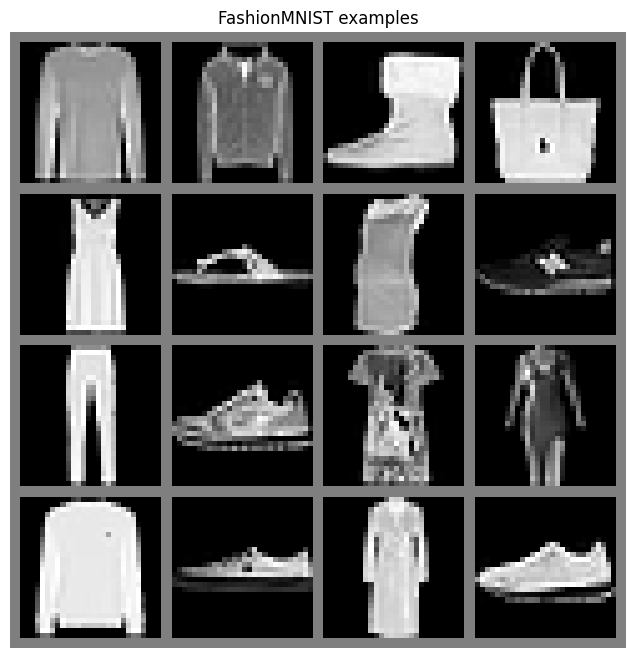

In [25]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Exercise 4

<div class="alert alert-success">

<p> Set up a neural network. The chosen network should view the images as 1D tensors and pushes them through a sequence of linear layers and a specified activation function. </p>

</div>



In [28]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out

In [26]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

For the activation functions, we make use of PyTorch’s torch.nn library instead of implementing ourselves. However, we also define an Identity activation function. Although this activation function would significantly limit the network’s modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity).



In [27]:
class Identity(nn.Module):
    def forward(self, x):
        return x

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to (1) visualize the weight/parameter distribution inside a network, (2) visualize the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.

In [28]:
import torch.nn.functional as F
import seaborn as sns
import math
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

When initializing a neural network, there are a few properties we would like to have.

1- First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model.

2- The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.



In [29]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
model = BaseNetwork(act_fn=Identity()).to(device)

###Constant initialization

The first initialization we can consider is to initialize all weights with the same constant value. Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero. However, what happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below and visualize the gradients.



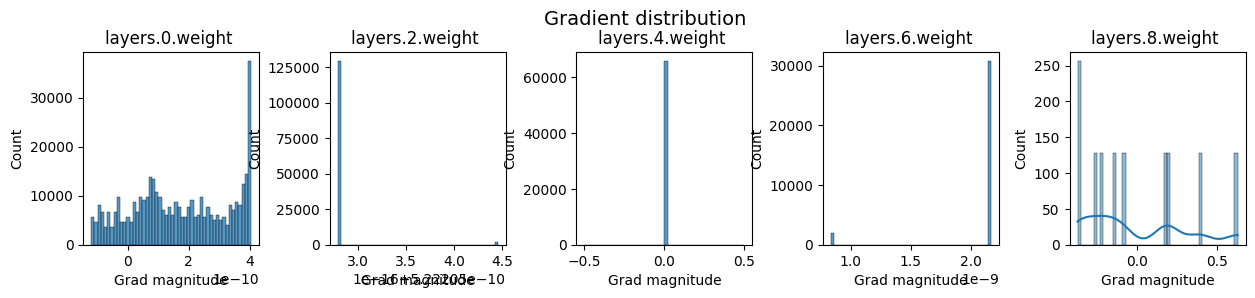

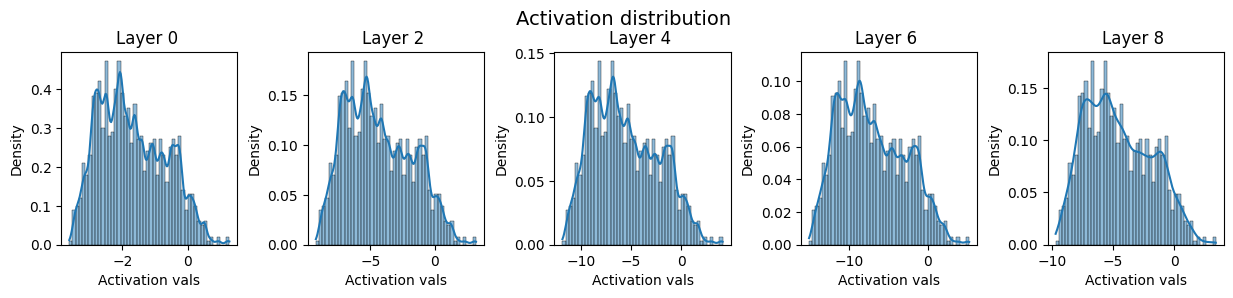

Layer 0 - Variance: 1.0037778615951538
Layer 2 - Variance: 6.578358173370361
Layer 4 - Variance: 10.777978897094727
Layer 6 - Variance: 17.65863800048828
Layer 8 - Variance: 7.232977867126465


In [30]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.


###Constant variance

From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network.

### Exercise 5

<div class="alert alert-success">

<p> Implement random initialization (with constant variance) below, and visualize the activation distribution across layers. </p>

</div>

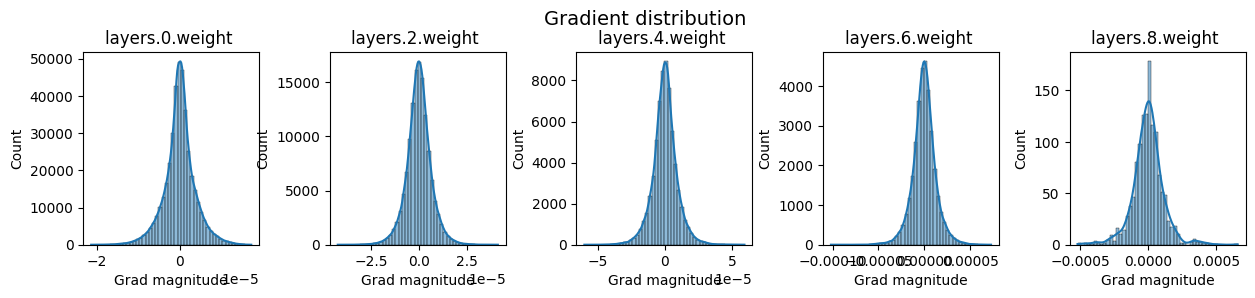

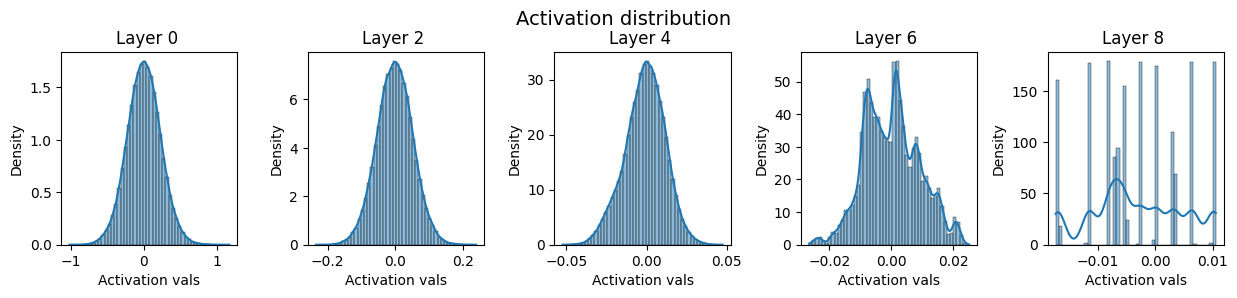

Layer 0 - Variance: 0.05306239053606987
Layer 2 - Variance: 0.00279003893956542
Layer 4 - Variance: 0.00015653522859793156
Layer 6 - Variance: 7.953387103043497e-05
Layer 8 - Variance: 6.282832327997312e-05


In [31]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer. Alternatively, we could use a higher standard deviation:

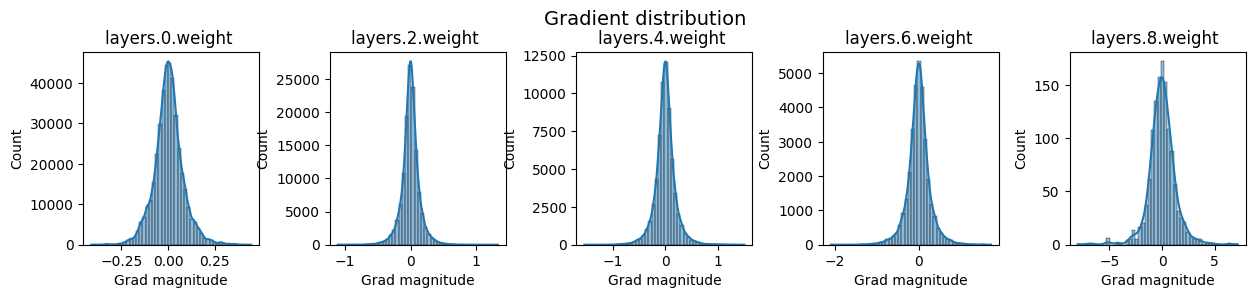

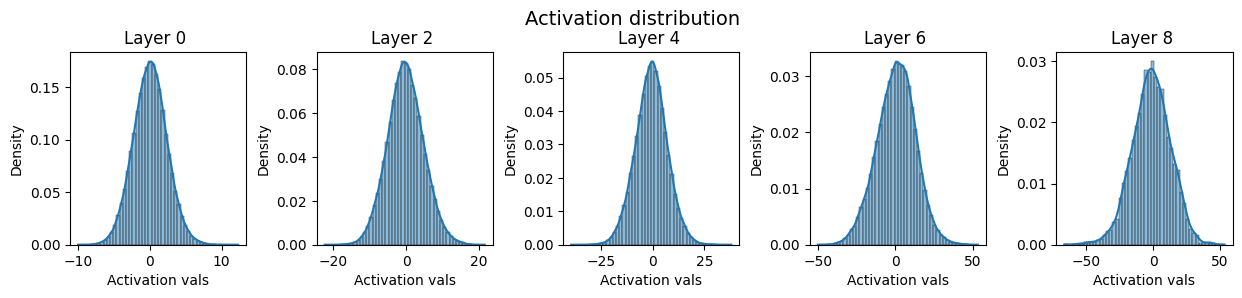

Layer 0 - Variance: 5.4563093185424805
Layer 2 - Variance: 24.376352310180664
Layer 4 - Variance: 58.82392120361328
Layer 6 - Variance: 152.33648681640625
Layer 8 - Variance: 205.4502410888672


In [33]:
var_init(model, std=0.1)
visualize_gradients(model)
visualize_activations(model, print_variance=True)


### How to find appropriate initialization values

From our experiments above, we have seen that we need to sample the weights from a distribution, but are not sure which one exactly. As a next step, we will try to find the optimal initialization from the perspective of the activation distribution. For this, we state two requirements:

1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer

Suppose we want to design an initialization for the following layer:

$y=Wx+b$ with $y\in\mathbb{R}^{d_y}$, $x\in\mathbb{R}^{d_x}$.

Our goal is that the variance of each element of $y$ is the same as the input, i.e. $\text{Var}(y_i)=\text{Var}(x_i)=\sigma_x^{2}$, and that the mean is zero. We assume $x$ to also have a mean of zero, because, in deep neural networks, $y$ would be the input of another layer. This requires the bias and weight to have an expectation of 0. Actually, as $b$ is a single element per output neuron and is constant across different inputs, we set it to 0 overall.

Next, we need to calculate the variance with which we need to initialize the weight parameters.
Along the calculation, we will need the following variance rule: given two independent variables, the variance of their product is $\text{Var}(X\cdot Y) = \mathbb{E}(Y)^2\text{Var}(X) + \mathbb{E}(X)^2\text{Var}(Y) + \text{Var}(X)\text{Var}(Y) = \mathbb{E}(Y^2)\mathbb{E}(X^2)-\mathbb{E}(Y)^2\mathbb{E}(X)^2$ ($X$ and $Y$ are not refering to $x$ and $y$, but any random variable).

The needed variance of the weights, $\text{Var}(w_{ij})$, is calculated as follows:

$$
\begin{split}
    y_i & = \sum_{j} w_{ij}x_{j}\hspace{10mm}\text{Calculation of a single output neuron without bias}\\
    \text{Var}(y_i) = \sigma_x^{2} & = \text{Var}\left(\sum_{j} w_{ij}x_{j}\right)\\
    & = \sum_{j} \text{Var}(w_{ij}x_{j}) \hspace{10mm}\text{Inputs and weights are independent of each other}\\
    & = \sum_{j} \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance rule (see above) with expectations being zero}\\
    & = d_x \cdot \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance equal for all $d_x$ elements}\\
    & = \sigma_x^{2} \cdot d_x \cdot \text{Var}(w_{ij})\\
    \Rightarrow \text{Var}(w_{ij}) = \sigma_{W}^2 & = \frac{1}{d_x}\\
\end{split}
$$

Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension $d_x$.

### Exercise 6

<div class="alert alert-success">

<p> Implement the idea above and check whether it works: </p>

</div>

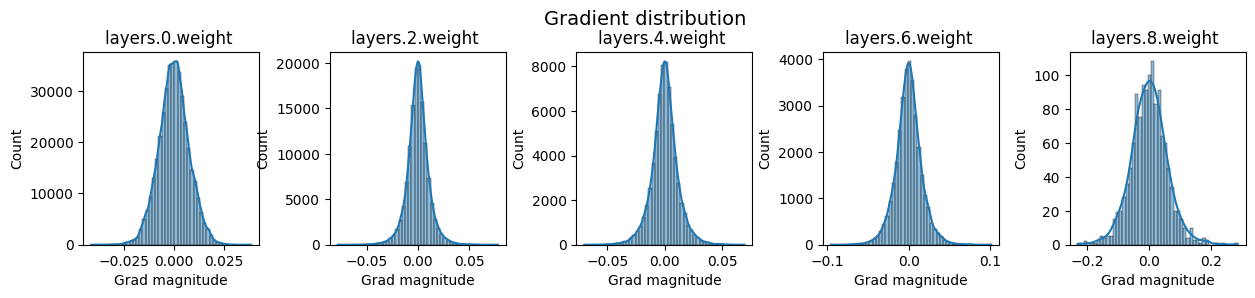

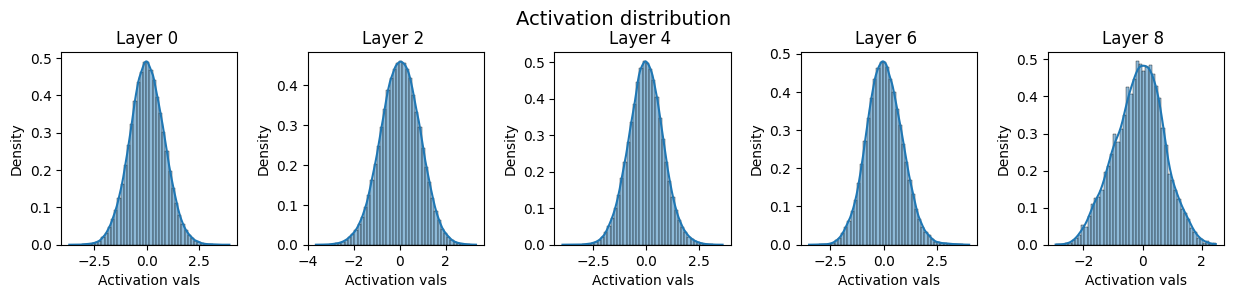

Layer 0 - Variance: 0.685444712638855
Layer 2 - Variance: 0.7250280380249023
Layer 4 - Variance: 0.6615312099456787
Layer 6 - Variance: 0.7036216855049133
Layer 8 - Variance: 0.6727268099784851


In [34]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))

equal_var_init(model)
visualize_gradients(model)
#visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As we expected, the variance stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of $1/d_x$. You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

Besides the variance of the activations, another variance we would like to stabilize is the one of the gradients. This ensures a stable optimization for deep networks. It turns out that we can do the same calculation as above starting from $\Delta x=W\Delta y$, and come to the conclusion that we should initialize our layers with $1/d_y$ where $d_y$ is the number of output neurons. You can do the calculation as a practice, or check a thorough explanation in [this blog post](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K). As a compromise between both constraints, [Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi) proposed to use the harmonic mean of both values. This leads us to the well-known Xavier initialization:

$$W\sim \mathcal{N}\left(0,\frac{2}{d_x+d_y}\right)$$

If we use a uniform distribution, we would initialize the weights with:

$$W\sim U\left[-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}}\right]$$

### Exercise 7

<div class="alert alert-success">

<p>
Let's shortly implement it and validate its effectiveness: </p>

</div>



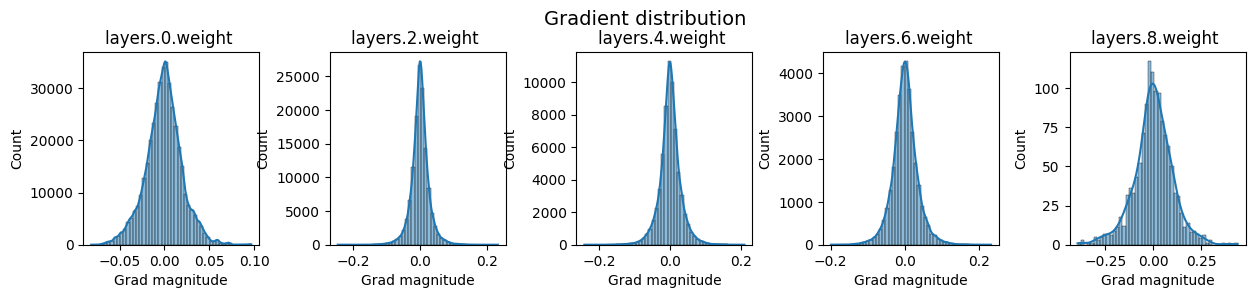

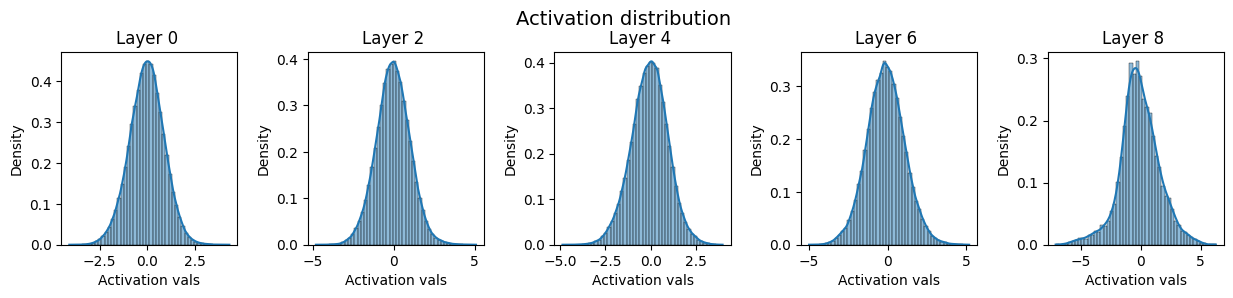

Layer 0 - Variance: 0.827303409576416
Layer 2 - Variance: 1.0899031162261963
Layer 4 - Variance: 1.013340711593628
Layer 6 - Variance: 1.4393646717071533
Layer 8 - Variance: 2.761659622192383


In [35]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)

xavier_init(model)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

We see that the Xavier initialization balances the variance of gradients and activations. Note that the significantly higher variance for the output layer is due to the large difference of input and output dimension ( 128  vs  10 ).

However, we currently assumed the activation function to be linear. So what happens if we add a non-linearity? In a tanh-based network, a common assumption is that for small values during the initial steps in training, the  tanh  works as a linear function such that we don't have to adjust our calculation. We can check if that is the case for us as well:

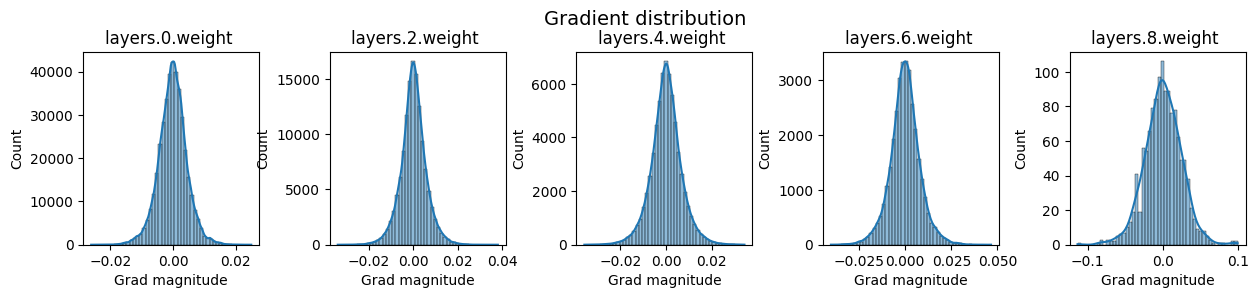

layers.0.weight - Variance: 2.0026423953822814e-05
layers.2.weight - Variance: 3.277640280430205e-05
layers.4.weight - Variance: 4.4338201405480504e-05
layers.6.weight - Variance: 6.445979670388624e-05
layers.8.weight - Variance: 0.0005920599796809256


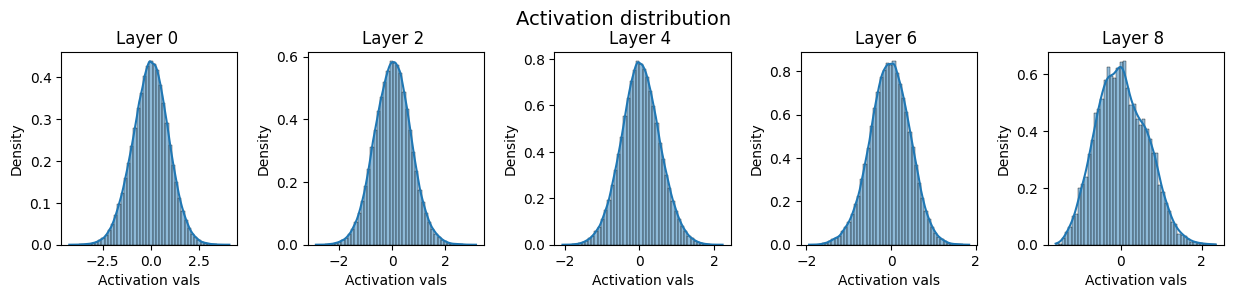

Layer 0 - Variance: 0.8722133636474609
Layer 2 - Variance: 0.47127872705459595
Layer 4 - Variance: 0.271274596452713
Layer 6 - Variance: 0.22289283573627472
Layer 8 - Variance: 0.3735221028327942


In [36]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Although the variance decreases over depth, it is apparent that the activation distribution becomes more focused on the low values. Therefore, our variance will stabilize around 0.25 if we would go even deeper. Hence, we can conclude that the Xavier initialization works well for Tanh networks.




## 4. Optimization algorithms

Besides initialization, selecting a suitable optimization algorithm can be an important choice for deep neural networks. Before taking a closer look at them, we should define code for training the models. Most of the following code is copied from the previous sections, and only slightly altered to fit our needs.

In [37]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function $w^{t} = f(w^{t-1}, g^{t}, ...)$ with $w$ being the parameters, and $g^{t} = \nabla_{w^{(t-1)}} L^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps.

As most optimizers only differ in the implementation of $f$, we can define a template for an optimizer in PyTorch below. We take as input the parameters of a model and a learning rate. The function `zero_grad` sets the gradients of all parameters to zero, which we have to do before calling `loss.backward()`. Finally, the `step()` function tells the optimizer to update all weights based on their gradients. The template is setup below:

In [38]:
class OptimizerTemplate:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

The first optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD). SGD updates the parameters using the following equation:

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$


#### Exercise 8

<div class="alert alert-success">

<p>
Implement SGD: </p>

</div>



In [44]:
class SGD(OptimizerTemplate):

    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

In the lecture, we also have discussed the concept of momentum which replaces the gradient in the update by an exponential average of all past gradients including the current one:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}\\
\end{split}
$$

Let's also implement it below:

#### Exercise 9

<div class="alert alert-success">

<p>
Implement SGD with momentum: </p>

</div>

In [49]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

Finally, we arrive at Adam. Adam combines the idea of momentum with an adaptive learning rate, which is based on an exponential average of the squared gradients, i.e. the gradients norm. Furthermore, we add a bias correction for the momentum and adaptive learning rate for the first iterations:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    v^{(t)} & = \beta_2 v^{(t-1)} + (1 - \beta_2)\cdot \left(g^{(t)}\right)^2\\
    \hat{m}^{(t)} & = \frac{m^{(t)}}{1-\beta^{t}_1}, \hat{v}^{(t)} = \frac{v^{(t)}}{1-\beta^{t}_2}\\
    w^{(t)} & = w^{(t-1)} - \frac{\eta}{\sqrt{\hat{v}^{(t)}} + \epsilon}\circ \hat{m}^{(t)}\\
\end{split}
$$

Epsilon is a small constant used to improve numerical stability for very small gradient norms. Remember that the adaptive learning rate does not replace the learning rate hyperparameter $\eta$, but rather acts as an extra factor and ensures that the gradients of various parameters have a similar norm.

#### Exercise 10

<div class="alert alert-success">
<p>
Implement Adam optimizer: </p>

</div>

In [52]:
class Adam(OptimizerTemplate):

    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)

### Pathological curvatures

A pathological curvature is a type of surface that is similar to ravines and is particularly tricky for plain SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction we have a slower gradient towards a (global) optimum. Let's first create an example surface of this and visualize it:

In [39]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

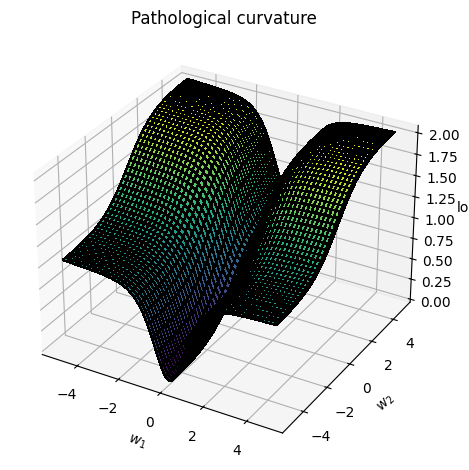

In [40]:
from matplotlib import cm

def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = plt.axes(projection='3d') if plot_3d else plt.axes()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid(x, y, indexing='xy')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In terms of optimization, you can image that $w_1$ and $w_2$ are weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $w_2$. However, if we encounter a point along the ridges, the gradient is much greater in $w_1$ than $w_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [41]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

Next, let's apply the different optimizers on our curvature. Note that we set a much higher learning rate for the optimization algorithms as you would in a standard neural network. This is because we only have 2 parameters instead of tens of thousands or even millions.

In [53]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

To understand best how the different algorithms worked, we visualize the update step as a line plot through the loss surface. We will stick with a 2D representation for readability.

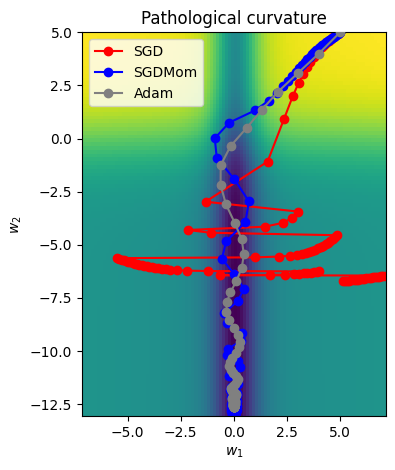

In [54]:
all_points = np.concatenate([SGD_points], axis=0)
all_points = np.concatenate([SGD_points, SGDMom_points], axis=0)
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)

ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

We can clearly see that SGD is not able to find the center of the optimization curve and has a problem converging due to the steep gradients in $w_1$. In contrast, Adam and SGD with momentum nicely converge as the changing direction of $w_1$ is canceling itself out. On such surfaces, it is crucial to use momentum.

### What optimizer to take

After seeing the results on optimization, what is our conclusion? Should we always use Adam and never look at SGD anymore? The short answer: no. There are many papers saying that in certain situations, SGD (with momentum) generalizes better where Adam often tends to overfit [5,6]. This is related to the idea of finding wider optima. For instance, see [Keskar et al., 2017](https://arxiv.org/pdf/1609.04836.pdf).

## Conclusion

In this tutorial, we have looked at commonly used activation functions, initialization, and optimization techniques for neural networks. We have seen that a good initialization has to balance the preservation of the gradient variance as well as the activation variance. In optimization, concepts like momentum and adaptive learning rate can help with challenging loss surfaces but don't guarantee an increase in performance for neural networks.




## References

[1] Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." Proceedings of the thirteenth international conference on artificial intelligence and statistics. 2010. [link](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

[2] He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015. [link](https://www.cv-foundation.org/openaccess/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html)

[3] Kingma, Diederik P. & Ba, Jimmy. "Adam: A Method for Stochastic Optimization." Proceedings of the third international conference for learning representations (ICLR). 2015. [link](https://arxiv.org/abs/1412.6980)

[4] Keskar, Nitish Shirish, et al. "On large-batch training for deep learning: Generalization gap and sharp minima." Proceedings of the fifth international conference for learning representations (ICLR). 2017. [link](https://arxiv.org/abs/1609.04836)

[5] Wilson, Ashia C., et al. "The Marginal Value of Adaptive Gradient Methods in Machine Learning." Advances in neural information processing systems. 2017. [link](https://papers.nips.cc/paper/7003-the-marginal-value-of-adaptive-gradient-methods-in-machine-learning.pdf)

[6] Ruder, Sebastian. "An overview of gradient descent optimization algorithms." arXiv preprint. 2017. [link](https://arxiv.org/abs/1609.04747)

[7] Lippe, Phillip. UvA Deep Learning Tutorials. https://github.com/phlippe/uvadlc_notebooks